In [1]:
import pandas as pd
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
shutil.unpack_archive('ECG5000.zip')

In [3]:
train = pd.read_csv('ECG5000_TRAIN.txt', delimiter= '\s+', index_col=False, header=None)
test = pd.read_csv('ECG5000_TEST.txt', delimiter= '\s+', index_col=False, header=None)

In [4]:
# Concatenate the Datasets
data = pd.concat((train, test))
data.shape

(5000, 141)

In [5]:
# Shuffle the Data
data = data.sample(frac=1.0).reset_index(drop=True)

In [6]:
data.columns = ['target'] + [str(i+1) for i in range(140)]

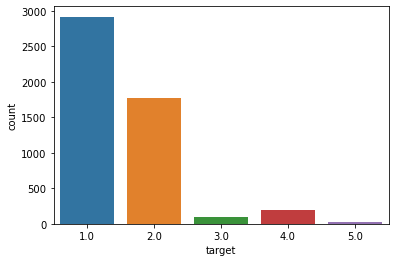

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: target, dtype: int64


In [7]:
sns.countplot(data=data, x='target')
plt.show()
print(data.target.value_counts())

- 1.0 represents the normal signal
- 2.0, 3.0, 4.0, 5.0 represents the anomaly signal

### Data Preprocessing

1 is Normal

0 is Anomaly

In [8]:
data['target'] = data['target'].apply(lambda x: 1 if x==1.0 else 0.0)

In [9]:
print(data.target.value_counts())

1.0    2919
0.0    2081
Name: target, dtype: int64


In [10]:
# Make Label y
y = data['target']

# Make Feature Batch
X = data.drop('target', axis=1)

In [11]:
# Train Test split of Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, shuffle=True)

In [12]:
y_train = y_train.astype(bool)

In [13]:
X_train_normal = X_train[y_train].values # All Normal Samples for Training
X_train_anomaly = X_train[~y_train].values # All Anomaly Samples for Evaluation

### Scaling

In [14]:
def minmax(scale_min=0.0, scale_max=1.0):
    max_val = np.max(X_train_normal)
    min_val = np.min(X_train_normal)
    X_train_normal = (scale_max - scale_min) * (X_train_normal - min_val) / (max_val - min_val) + scale_min
    X_train_anomaly = (scale_max - scale_min) * (X_train_anomaly - min_val) / (max_val - min_val) + scale_min
    X_test = (scale_max - scale_min) * (X_test - min_val) / (max_val - min_val) + scale_min
    return X_train_normal, X_train_anomaly, X_test
    

def standardize():
    mean = np.mean(X_train_normal)
    std = np.std(X_train_normal)
    X_train_normal = (X_train_normal - mean) / std
    X_train_anomaly = (X_train_anomaly - mean) / std
    X_test = (X_test - mean) / std
    return X_train_normal, X_train_anomaly, X_test
    
    
    
X_train_normal, X_train_anomaly, X_test = standardize()
#X_train_normal, X_train_anomaly, X_test = minmax()

UnboundLocalError: local variable 'X_train_normal' referenced before assignment

### Fully Connected Neural Network Autoencoder

In [ ]:
model_dense = tf.keras.Sequential([
    Dense(64, activation='relu', input_shape=(140,)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),  # Bottleneck Layer
    Dense(16, activation='relu'),
    Dense(64, activation='relu'),
    Dense(140, activation='relu')
])
model_dense.compile(optimizer='adam', loss='mse')
print(model_dense.summary())

In [ ]:
def train(model,
          X_train,
          X_eval,
          epochs=20):
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    X_eval = tf.convert_to_tensor(X_eval, dtype=tf.float32)

    # Train model on Normal Train Data (Normal Data Only)
    # Validate Model on complete Test Set (Normal + Anomaly)
    history = model.fit(X_train,
                        X_train,
                        epochs=epochs,
                        #batch_size=500,
                        validation_data=(X_eval, X_eval),
                        shuffle=True)
    
    # Plot Losses
    plt.figure()
    plt.plot(history.history['loss'], label='Normal Data Loss')
    plt.plot(history.history['val_loss'], label='Anomaly Data Loss')
    plt.legend()
    plt.show()

    # Reconstruction Losses of Normal + Anomaly Data
    train_pred = model.predict(X_train)
    train_loss = tf.keras.losses.mae(train_pred, X_train).numpy()
    print('Train Loss', np.mean(train_loss))

    test_pred = model.predict(X_eval)
    val_loss = tf.keras.losses.mae(test_pred, X_eval).numpy()
    print('Test Loss', np.mean(val_loss))
    
    sns.histplot(train_loss, color='green', kde=True)    
    sns.histplot(val_loss, color='yellow', kde=True)
    plt.show()
    

In [ ]:
train(model_dense,
      X_train=X_train_normal,
      X_eval=X_train_anomaly,
      epochs=40)

In [ ]:
def show_recon_series(model, batch=X_test.values, labels=y_test.values):
    pred = model.predict(batch)
    pred_losses = tf.keras.losses.mae(pred, batch).numpy()
    
    sns.histplot(pred_losses, color='black', kde=True)
    plt.show()
    
    for i in range(10):
        if labels[i] == 0:
            label = 'Anomaly'
        else:
            label = 'Normal'
        plt.plot(pred[i], label='Prediction')
        plt.plot(batch[i, :], label='True')
        plt.title(label + '  Loss:' + str(np.round(pred_losses[i],2)))
        plt.legend()
        plt.show()

In [ ]:
show_recon_series(model=model_dense)